# Tutorial: global_ocean.cs32x15

### Written by M. Wood. June 2021

This verification experiment is almost identical to the global_ocean.cs32x15 experiment configured with the files in the `global_ocean.cs32x15/input.seaice` directory, except that it uses `diagnostics_vec` to output variables from the model and compares them to variables from the `diagnostics` package to show that the two packages are identical.

The `global_ocean.cs32x15` experiment provides a demonstration of a cubed sphere configuration that utilizes the exch2 package. Numerically, the model grid stacked horizontally in a long array, with tile connections described by the data.exch2 file (or defined implicitly in the package code). Here, we demonstrate that the `diagnostics_vec` package handles configurations that utilize the exch2 (and seaice) package.

This tutorial follows 5 steps:
1. Prepare the configuration
2. Prepare the diagnostic_vec masks
3. Build the model
4. Run the model
5. Compare diagnostics_vec vs diagnostics_output


### 1. Prepare the configuration
To prepare the configuration, `cd` to the `input_dv` directory within the `global_ocean.cs32x15`  experiment. As for the code in the base experiment `input` directory, we provide a **prepare_run** script which can be used to generate all of the necessary files (aside from the few already provided). Run this from the command line, e.g.:

### 2. Prepare the diagnostics_vec masks

The diagnostics_vec masks are generated using a simple Python script, `create_masks.py`, which is additionally provided in the input_dv directory. Create the masks (from within the input_dv directory) by running the script:

This script creates two masks - one which transverses the global along the equator, and one which covers the south pole (used to compare sea ice diagnostics below). To view these masks relative to the model bathymetry, we can read and plot them as follows:

['.DS_Store', 'build', 'build_dv.sh', 'build_dv_mpi.sh', 'code', 'code_ad', 'code_alt', 'code_dv', 'input', 'input.icedyn', 'input.seaice', 'input.thsice', 'input.viscA4', 'input_ad', 'input_ad.seaice', 'input_ad.seaice_dynmix', 'input_ad.thsice', 'input_dv.seaice', 'README', 'results', 'run', 'run_dv.sh', 'run_dv_mpi.sh']


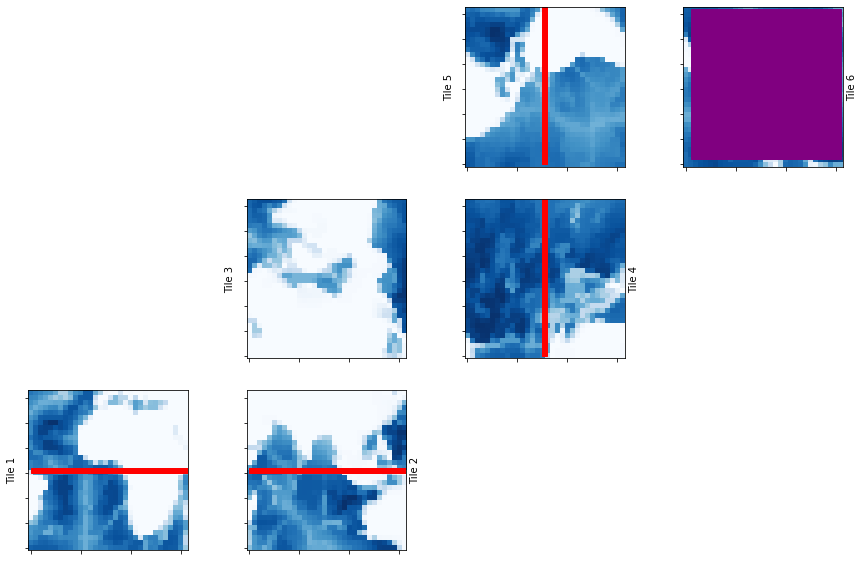

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# set the path to the input directory (UPDATE FOR YOUR SYSTEM)
input_dir = '../../../MITgcm/MITgcm_fresh/verification/global_ocean.cs32x15/input_dv.seaice'

# read in the model bathymetry
bathy_file = os.path.join(input_dir, 'bathy_Hmin50.bin')
bathy_grid = np.fromfile(bathy_file, dtype='>f8')
bathy_grid = np.reshape(bathy_grid, (32, 6, 32))

# read in the mask files
equator_file = os.path.join(input_dir, 'equator_mask.bin')
equator_mask = np.fromfile(equator_file, dtype='>f8')
equator_mask = np.reshape(equator_mask, (32, 6, 32))

south_pole_file = os.path.join(input_dir, 'south_pole_mask.bin')
south_pole_mask = np.fromfile(south_pole_file, dtype='>f8')
south_pole_mask = np.reshape(south_pole_mask, (32, 6, 32))

# plot the masks on the bathymetry (in a coherent fashion)
fig = plt.figure(figsize=(15,10))
tile_array_to_plot_IJ = {1:[3,1],2:[3,2],3:[2,2],4:[2,3],5:[1,3],6:[1,4]}
mask_plot_colors = ['red','purple']

for i in range(1,7):
    row = tile_array_to_plot_IJ[i][0]
    col = tile_array_to_plot_IJ[i][1]
    plot_counter = (row-1)*4+col
    plt.subplot(3,4,plot_counter)

    # plot the var
    C = plt.imshow(bathy_grid[:,i-1,:],origin='lower',cmap='Blues_r',
                   vmin=np.min(bathy_grid),vmax = np.max(bathy_grid))

    # plot the equator mask (where its positive)
    mask_subset = equator_mask[:,i-1,:]
    rows, cols = np.where(mask_subset != 0)
    for pt in range(len(rows)):
        rect = Rectangle((cols[pt], rows[pt]), 1, 1, color='red')
        plt.gca().add_patch(rect)
    
    # plot the south_pole mask (where its positive)
    mask_subset = south_pole_mask[:,i-1,:]
    rows, cols = np.where(mask_subset != 0)
    for pt in range(len(rows)):
        rect = Rectangle((cols[pt], rows[pt]), 1, 1, color='purple')
        plt.gca().add_patch(rect)
        
    # annotate the subplot
    if i%2==0:
        plt.gca().yaxis.set_label_position("right")
    plt.ylabel('Tile '+str(i))
    # plt.colorbar(C)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    # plt.title(str(i))
    # plt.suptitle('Mask: '+mask_name)
plt.show()


### 3. Build the model
For this experiement, we provide options for configuring the model with and without MPI. Build the model according to your system specifications. For example, your build might follow the following commands:

### 4. Run the model
With the model built, run it as you would on your system. For example:

### 5. Compare Diagnostics_vec vs Standard Model Output

In [10]:
# set the path to the run directory (UPDATE FOR YOUR SYSTEM)
run_dir = '../../../MITgcm/MITgcm_fresh/verification/global_ocean.cs32x15/run'

Nx = 90
Ny = 40
nTimesteps = 10
Nr = 15

Text(0.5, 1.0, 'Timeseries Comparison at Depth Cell 3')

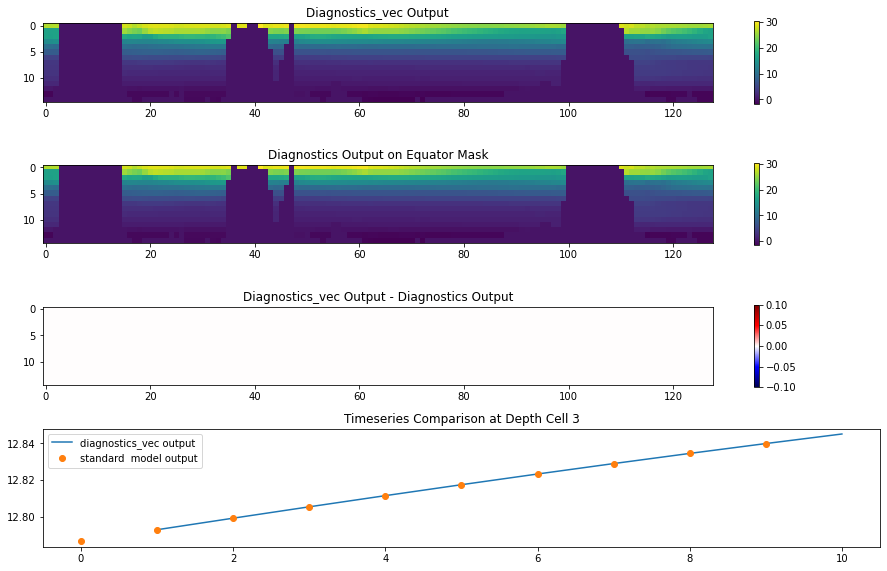

In [50]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'THETA' # THETA, SALT, UVEL, VVEL, or WVEL
mask_name = 'south' # north, south, east, or west
comparison_timestep = 3 # up to 10
test_col = 72 # up to 127
test_depth_level = 3

# read in the diagnostics_vec output
file_path = os.path.join(run_dir,'equator_mask_'+var_name+'.bin')
diag_vec_output = np.fromfile(file_path,'>f8')
diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,Nr,128))

# read in the diagnostics output
file_prefix = os.path.join(run_dir,'stateDiag')
diagnostics_output = rdmds(file_prefix,np.arange(72001,72011).tolist())
var_index = ['THETA','SALT','UVE','VVEL'].index(var_name)
diagnostics_output = diagnostics_output[:,var_index,:,:,:]

# read in the equator mask
mask_path = os.path.join(run_dir,'equator_mask.bin')
diag_vec_mask = np.fromfile(mask_path,'>f8')
diag_vec_mask = np.reshape(diag_vec_mask,(32, 192))

# subset the diagnostics_output on the equator mask
N = int(np.max(diag_vec_mask))
diagnostics_subset = np.zeros((nTimesteps,Nr,N))
for n in range(1,N+1):
    row,col = np.where(diag_vec_mask==n)
    diagnostics_subset[:,:,n-1] = diagnostics_output[:,:,row[0],col[0]]
    

diag_vec_timeseries = diag_vec_output[:,test_depth_level,test_col]
diagnostics_timeseries = diagnostics_subset[:,test_depth_level,test_col]

diag_vec_comparison_field = diag_vec_output[comparison_timestep-1,:,:] #no IC's here
diagnostics_comparison_field = diagnostics_subset[comparison_timestep,:,:]

plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
C = plt.imshow(diag_vec_comparison_field)
plt.colorbar(C, shrink=0.7)
plt.title('Diagnostics_vec Output')

plt.subplot(4,1,2)
C = plt.imshow(diagnostics_comparison_field)
plt.colorbar(C, shrink=0.7)
plt.title('Diagnostics Output on Equator Mask')

plt.subplot(4,1,3)
C = plt.imshow(diag_vec_comparison_field-diagnostics_comparison_field,cmap='seismic')
plt.colorbar(C, shrink=0.7)
plt.title('Diagnostics_vec Output - Diagnostics Output')

plt.subplot(4,1,4)
plt.plot(np.arange(1,11),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot(np.arange(0,10),diagnostics_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison at Depth Cell '+str(test_depth_level))

#### Compare the surface (seaice) variables
Next, we can compare the seaice fielda as output from diagnostics_vec and diagnostics:

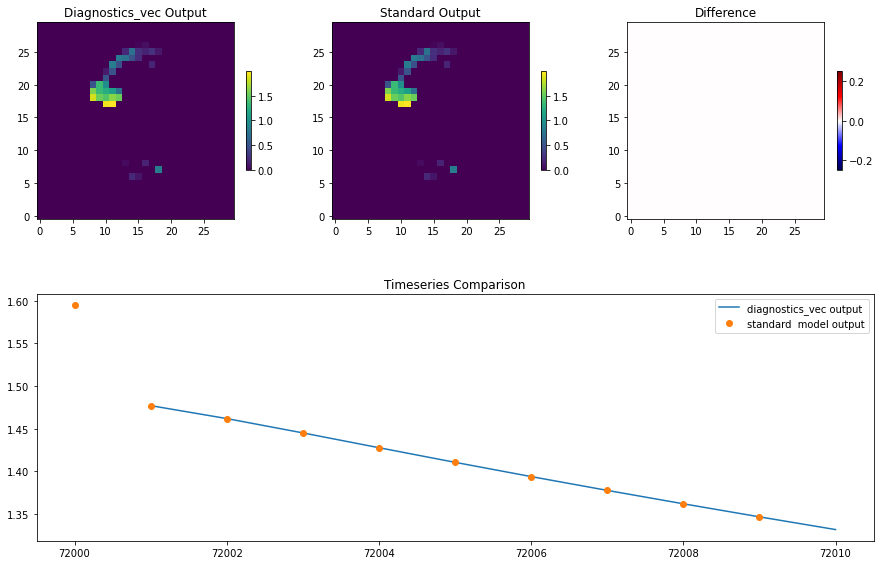

In [24]:
from MITgcmutils.mds import rdmds

# choose some parameters to plot 
var_name = 'HEFF' # AREA, HEFF, HSNOW, UICE, VICE
comparison_timestep = 3
test_row = 18 # between 0 and 20 (=max_row - min_row)
test_col = 10 # between 0 and 40 (=max_col - min_col)

# read in the diagnostics_vec output
file_path = os.path.join(run_dir,'south_pole_mask_'+var_name+'.bin')
diag_vec_output = np.fromfile(file_path,'>f8')
diag_vec_output = np.reshape(diag_vec_output,(nTimesteps,30,30))
diag_vec_timeseries = diag_vec_output[:,test_row,test_col]
diag_vec_comparison_field = diag_vec_output[comparison_timestep-1,:,:] #no IC's here

# # read in the diagnostics output
file_prefix = os.path.join(run_dir,'seaiceDiag')
diagnostics_output = rdmds(file_prefix,np.arange(72001,72011).tolist())
var_index = ['HEFF','AREA','HSNOW','UICE','VICE'].index(var_name)
diagnostics_comparison_field = diagnostics_output[comparison_timestep,var_index,:,:,]
diagnostics_comparison_field = np.reshape(diagnostics_comparison_field,(32,6,32))
diagnostics_comparison_field = diagnostics_comparison_field[1:31,5,1:31]
diagnostics_timeseries = diagnostics_output[:,var_index,:,:,]
diagnostics_timeseries = np.reshape(diagnostics_timeseries,(10,32,6,32))
diagnostics_timeseries = diagnostics_timeseries[:,1+test_row,5,1+test_col]

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
C = plt.imshow(diag_vec_comparison_field,origin='lower')
plt.colorbar(C, shrink=0.4)
plt.title('Diagnostics_vec Output')

plt.subplot(2,3,2)
C2 = plt.imshow(diagnostics_comparison_field,origin='lower')
plt.colorbar(C2, shrink=0.4)
plt.title('Standard Output')

plt.subplot(2,3,3)
C3 = plt.imshow(diag_vec_comparison_field - diagnostics_comparison_field,origin='lower',
                cmap='seismic',vmin=-0.25,vmax=0.25)
plt.colorbar(C3, shrink=0.4)
plt.title('Difference')

plt.subplot(2,1,2)
plt.plot(np.arange(72001,72011).tolist(),diag_vec_timeseries,label='diagnostics_vec output')
plt.plot(np.arange(72000,72010).tolist(),diagnostics_timeseries,'.',markersize=12,
         label='standard  model output')
plt.legend()
plt.title('Timeseries Comparison')
plt.show()